In [1]:
import sys
sys.path.append('../../')
from Backtest import Backtest,Position,Bid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import yfinance as yf
import pickle
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_data(tickers,length,interval):
    data =  yf.download(tickers = tickers, 
    period = length, interval = interval, group_by = 'ticker',
    auto_adjust = True,
    prepost = False,
    threads = True,
    proxy = None
)

    data = data.loc[:, pd.IndexSlice[:, ['Close']]]

    columns = data.columns.droplevel(1)

    data.columns = columns 

    data.sort_index(axis = 1, inplace = True)
    #data = data.reset_index(drop = True)
    return data.dropna()

In [3]:
with open("sp100tickers.pickle", "rb") as f:
            tickers = pickle.load(f)

In [4]:
#data = get_data(tickers,'1440d','1d')
data = pd.read_csv("test_data.csv",index_col = 0)
data.index = pd.to_datetime(data.index)
data

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-20,45.672226,67.746773,75.681816,158.183182,259.739990,38.793434,172.204147,177.789688,89.863503,256.562775,...,237.594376,149.610031,97.356354,44.043068,150.371948,48.581097,54.631924,45.600048,93.002449,66.370712
2019-03-21,47.354343,68.429039,75.795403,160.057327,264.179993,39.217850,172.897949,180.732117,90.962997,261.649475,...,239.036133,151.106140,99.052338,43.422256,152.376923,49.103390,55.336681,45.111477,93.398445,66.754303
2019-03-22,46.373714,67.182434,73.816734,157.203217,259.690002,38.486416,168.221588,179.748230,88.238503,257.990936,...,234.360107,149.256927,96.842163,42.215588,149.706924,50.341709,54.301296,43.709091,92.663010,65.685143
2019-03-25,45.813011,66.971848,74.062904,157.051041,262.269989,38.332909,168.122467,181.641785,88.712997,257.558960,...,234.141953,150.074631,96.436188,42.058201,149.667770,50.611271,53.674843,43.500996,92.559303,65.228065
2019-03-26,45.339684,68.024742,74.791878,158.820541,265.589996,38.874706,169.636185,181.047699,89.188004,261.852234,...,230.850708,150.362686,97.798386,42.416702,151.887848,51.074593,53.874958,44.342426,92.700722,66.076881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30,138.199997,134.210007,96.760002,257.299988,275.200012,47.480000,225.399994,213.145813,113.000000,444.010010,...,505.040009,194.820007,161.539993,40.320000,177.649994,37.340702,31.400000,40.220001,129.699997,87.309998
2022-10-03,142.449997,138.320007,99.519997,264.890015,285.239990,49.180000,230.440002,215.597931,115.879997,456.779999,...,515.510010,200.259995,163.089996,41.570000,181.649994,38.510979,32.430000,41.580002,132.529999,91.919998
2022-10-04,146.100006,141.990005,103.080002,274.309998,294.970001,51.709999,233.020004,218.486877,121.089996,479.859985,...,523.169983,205.380005,168.889999,42.630001,185.649994,39.150208,33.389999,43.540001,134.250000,95.269997


In [5]:
class EXP3:
    def __init__(self,data,gamma):
        self.data = data.pct_change()
        self.tickers = self.data.columns
        self.data.columns = [i for i in range(len(self.tickers))]
        self.num_actions = len(self.data.columns)
        self.gamma = gamma
        self.weights = [1]*self.num_actions
        
        self.ProbabilityDistr = pd.DataFrame(columns = self.tickers)
        
    
        
        self.regrets = []
        self.current_hold = -1
        self.rewards = []
        self.gammas = []
    #get current distribution
    def get_distr(self):        
        theSum = float(sum(self.weights))
        return tuple((1.0 - self.gamma) * (w / theSum) + (self.gamma / len(self.weights)) for w in self.weights)
    
    
    #draw an action from distribution
    def draw(self,weights):
        choice = random.uniform(0, sum(weights))
        choiceIndex = 0
        for weight in weights:
            choice -= weight
            if choice <= 0:
                return choiceIndex
            choiceIndex += 1
    
    def reset(self):
        self.rewards = []
        self.weights = [1]*self.num_actions
    
    def buy(self,ti):
        df_X = self.data.iloc[:i]
        df_X[]
        
        
        
        
        
    def predict(self,ti,df,positions,cash,full_data):
        bid_list = []
        #sell the previous one
        
        for pos in positions.values():
            ticker = pos.ticker
            price = df.iloc[-1][pos.ticker]
            shares_held = pos.shares
            
            bid = Bid(ticker = ticker,shares = shares_held,price = price,bid_type = 0)
            bid_list.append(bid)
            
            cash += shares_held*price
            

            

        if self.current_hold != -1:
            #reward
            reward = self.data.loc[ti,self.current_hold]
            
            #scaled_reward
            min_ret = min(self.data.loc[ti])
            max_ret = max(self.data.loc[ti])
            mean_ret = sum(self.data.loc[ti])/len(self.data.loc[ti])

            scaled_reward = (reward-mean_ret)/(max_ret-min_ret)
            
            
            
            self.rewards.append(scaled_reward)
            #esitimated_reward
            
            estimatedReward = 1.0 * scaled_reward / self.ProbabilityDistr.iloc[-1][self.current_hold]
            self.weights[self.current_hold] *= np.exp(estimatedReward * self.gamma / self.num_actions)
        
        #take another action
        ProbabilityDistribution = self.get_distr()
        self.ProbabilityDistr.loc[len(self.ProbabilityDistr)] = ProbabilityDistribution
        choice = self.draw(ProbabilityDistribution)
        self.current_hold = choice
        
        for ticker in self.tickers:
            amount = cash*self.ProbabilityDistr.iloc[-1][ticker]
            price = df.iloc[-1][ticker]
            shares = amount//price
            bid = Bid(ticker = ticker,shares = shares,price = price,bid_type = 1)
            bid_list.append(bid)
            

        self.current_hold = choice
        
        return bid_list


In [8]:
data1 = data.iloc[:,70:80]
exp3 = EXP3(data1,0.4)
exp3_bt = Backtest(data1,exp3)
exp3_bt.backtest_full()

<AxesSubplot:>

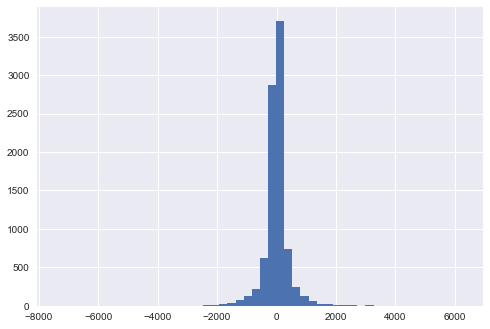

In [9]:
exp3_bt.transaction_history['pnl'][exp3_bt.transaction_history.type == 0].hist(bins = 50)

In [10]:
exp3_bt.transaction_history

,dt,ticker,type,price,shares,amount,transaction_cost,pnl
0,2019-03-20,NKE,1,83.912529,119.0,9985.590950,0.0,0.0
1,2019-03-20,NVDA,1,43.336212,230.0,9967.328796,0.0,0.0
2,2019-03-20,ORCL,1,49.685425,201.0,9986.770386,0.0,0.0
3,2019-03-20,PEP,1,107.181427,93.0,9967.872711,0.0,0.0
4,2019-03-20,PFE,1,35.146038,284.0,9981.474808,0.0,0.0
...,...,...,...,...,...,...,...,...
17915,2022-10-07,PG,0,124.269997,83.0,10314.409721,0.0,0.0
17916,2022-10-07,PM,0,84.650002,113.0,9565.450172,0.0,0.0
17917,2022-10-07,PYPL,0,90.169998,313.0,28223.209427,0.0,0.0
17918,2022-10-07,QCOM,0,120.910004,209.0,25270.190765,0.0,0.0


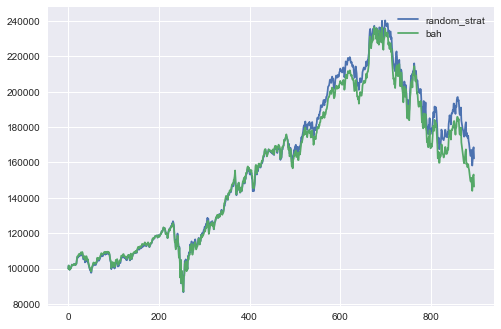

In [11]:
plt.style.use('seaborn')
exp3_bt.plot()

In [12]:
exp3_bt.portfolio_tracker

,dt,bid_count,position_count,cash_value,positions_value,total_value,bah
0,2019-03-20,10,10,248.462112,99751.537888,100000.000000,100000.000000
1,2019-03-21,20,10,283.166542,101431.137905,101714.304447,101719.086596
2,2019-03-22,20,10,386.992241,99276.174820,99663.167061,99677.910952
3,2019-03-25,20,10,394.587612,98906.981926,99301.569538,99344.428927
4,2019-03-26,20,10,333.356293,100195.353092,100528.709385,100563.168486
...,...,...,...,...,...,...,...
891,2022-09-30,20,10,505.314453,157752.430428,158257.744881,143946.104325
892,2022-10-03,20,10,374.224449,161231.480476,161605.704926,147381.891988
893,2022-10-04,20,10,386.124474,167004.090843,167390.215317,152370.271558
894,2022-10-05,20,10,519.224518,168098.298943,168617.523460,153187.275279


In [ ]:
exp3_bt